# Egg Tray MRI Transformation Pipeline – Report

## 1. Objective:

Develop a maintainable and extendable transformation pipeline to automatically extract individual 3D egg volumes from a wide-field MRI tray scans. The pipeline ensures data integrity by assigning consistent, position-based IDs to each egg, enabling reliable analysis and machine learning workflows.

#### Pipeline Overview:
- Takes a full 3D MRI scan of an egg tray as input.
- Segments and extracts individual 3D egg volumes.
- Assigns a stable egg ID using a centroid-based grid sorting scheme aligned with a reference image.
- Outputs egg-wise 3D MRI volume.

#### Inputs:

1. **3D NIfTI MRI scan** of an egg tray (12 eggs)
2. **2D reference image** defining fixed egg position IDs (1–12)

#### Assumptions:
- The tray contains 3 rows and 4 columns, with IDs ordered as in the reference image.
- The tray is approximately straight. Minor tilt is acceptable and handled by row-wise centroid clustering.
- Each scan is a static snapshot. We don't need to track eggs moving over time.
- The Tray is expected to contain 12 eggs. If fewer instances are detected, the pipeline continue with warning.

## 2. Approach and Pipeline Design

A **geometry-first approach** is used, leveraging the predictable grid layout of the tray. This design ensures a fast, reliable, and interpretable pipeline without requiring complex deep learning models.

#### Core Methods:
- **Preprocessing**:
    - Intensity normalization using robust percentiles (e.g., 1st–99th) to reduce the impact of outliers.
    - 3D Gaussian smoothing to suppress noise and stabilize thresholding.

- **Segmentation:**
    - Global Otsu thresholding on the preprocessed 3D volume to separate eggs from background.
    - Morphological opening with a 3D structuring element to remove small noise and artifacts.

- **Instance Extraction:**
    - 3D connected-component labeling on the binary mask.
    - Retention of the 12 largest connected components (by voxel count) as egg candidates, with a warning if fewer than 12 are found.

- **Stable ID Assignment:**
    - Computation of 3D centroids for each instance.
    - Sorting by vertical coordinate to group eggs into rows using a configurable row-tolerance on the Y coordinate.
    - Within each row, sorting by horizontal (X) coordinate to obtain a left-to-right order.
    - IDs are then assigned sequentially (1–12) in row-major order, consistent with the reference image layout.

- **Volume Extraction and Export:**
    - For each labeled egg mask, computation of a padded 3D bounding box with safe boundary checks.
    - Cropping the original MRI volume to this bounding box to obtain an individual 3D egg volume.
    - Saving each egg-specific volume as a separate NIfTI file for downstream use.



## 3. Step-by-Step Visualization

### 3.1 Load MRI Volume

In [25]:
import nibabel as nib

nii = nib.load("data/mri-egg-tray.nii")
volume = nii.get_fdata()

print("Volume shape:", volume.shape)
print("Intensity range:", volume.min(), volume.max())

Volume shape: (150, 150, 80)
Intensity range: 0.0015133672587720366 34.378540522164776


### 3.2 Raw MRI Slice

The central slice shows 12 clearly separated eggs arranged in a 3×4 grid.

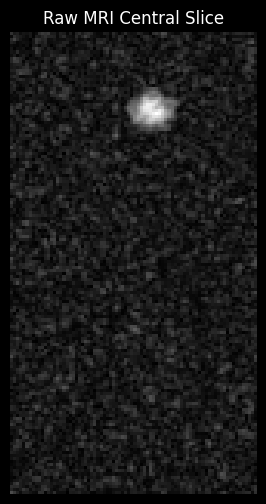

In [26]:
z = volume.shape[0] // 2

plt.figure(figsize=(6,6))
plt.imshow(volume[z], cmap="gray")
plt.title("Raw MRI Central Slice")
plt.axis("off")
plt.show()

### 3.3 Preprocessing

In [29]:
from scipy.ndimage import gaussian_filter
import numpy as np

v_min, v_max = np.percentile(volume, (1, 99))
normalized = np.clip((volume - v_min) / (v_max - v_min), 0, 1)
processed = gaussian_filter(normalized, sigma=1.0)


### 3.4 Segmentation

In [31]:
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, ball

th = threshold_otsu(processed)
mask = processed > th
mask = binary_opening(mask, ball(2))

### 3.5 Connected Components (3D)

In [32]:
from scipy.ndimage import label

labeled, num_instances = label(mask)
print("Detected objects:", num_instances)

Detected objects: 25


### 3.6 Extract 12 Largest Components

In [33]:
sizes = np.bincount(labeled.ravel())
largest = np.argsort(sizes[1:])[::-1][:12] + 1

instances = [(labeled == idx) for idx in largest]

### 3.7 Crop Eggs

In [34]:
def crop(volume, mask, padding=5):
    coords = np.argwhere(mask)
    z_min, y_min, x_min = coords.min(axis=0) - padding
    z_max, y_max, x_max = coords.max(axis=0) + padding

    return volume[
        max(0,z_min):z_max,
        max(0,y_min):y_max,
        max(0,x_min):x_max
    ]

egg_volumes = [crop(volume, m) for m in instances]

### 3.8 Show Cropped Eggs

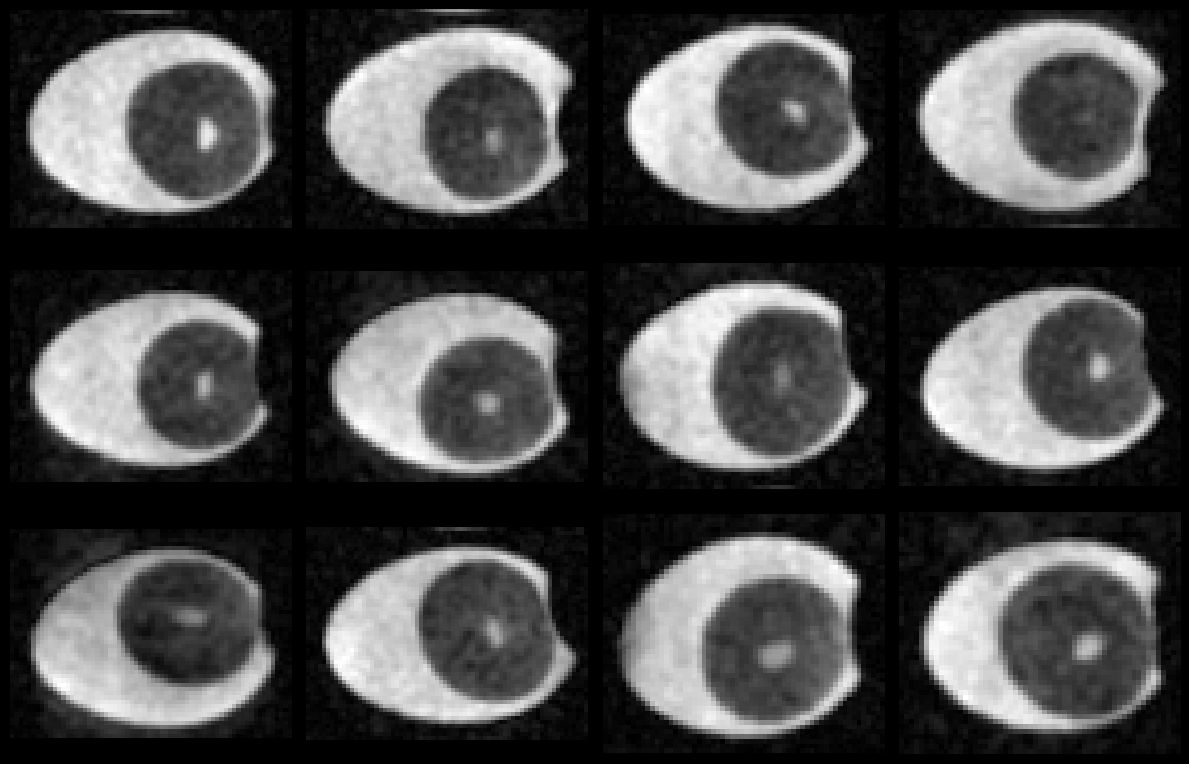

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for ax, egg in zip(axes.flat, egg_volumes):
    z_mid = egg.shape[0] // 2
    ax.imshow(egg[z_mid], cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Scalability & Limitations

- The pipeline scales linearly with volume size and supports parallel per-egg processing after segmentation.
- It currently assumes a fixed 3×4 tray layout with deterministic row-major ID ordering.
- Different tray geometries would require adapting the centroid-based row clustering logic.
- Touching or heavily rotated eggs would require more advanced instance segmentation methods.

The proposed pipeline provides a modular and deterministic solution for extracting and consistently labeling individual egg volumes from tray-level MRI scans, while remaining extensible for future enhancements.